In [7]:
import pandas as pd
import jupyter as jp
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from pathlib import Path
from datetime import datetime
from datetime import timedelta

response = requests.post('https://oauth.battle.net/token', auth=('', ''), data={'grant_type': 'client_credentials'})
if response.status_code == 200:
    access_token = response.json()['access_token']
    print('Access token:', access_token)
else:
    print('Failed to retreive access token')
    print("status code:", response.status_code)
    print('Response:', response.text)

## Get list of Realms

In [269]:
access_token = "USpJZEkuqyNQmsXqh0mv0l1rQ7VvhINYiU"  # Replace with your actual access token

api_url = "https://us.api.blizzard.com/data/wow/realm/index"
namespace = "dynamic-us"  # Adjust as necessary
locale = "en_US"  # Locale can be adjusted as needed

headers = {
    'Authorization': f'Bearer {access_token}',
    'Battlenet-Namespace': namespace,
    'locale': locale
}

response = requests.get(api_url, headers=headers)

if response.status_code == 200:
    realms_data = response.json()
    list_of_realms=[]
    realm_ids=[]
    realm_names=[]
    for realm in realms_data.get('realms', []):
        list_of_realms.append((realm['id'], realm['name']['en_US']))
        realm_ids.append(realm['id'])
        realm_names.append(realm['name']['en_US'])
    list_of_realms.sort()
else:
    print('Failed to retrieve realm data')
    print('Status Code:', response.status_code)
    print('Response:', response.text)

In [270]:
list_of_realms
realms_df=pd.DataFrame({'realm_id':realm_ids,
                       'realm_name':realm_names})
realms_df.sort_values(by='realm_id', inplace=True)
realms_df.set_index('realm_id')

,realm_name
realm_id,
1,Lightbringer
2,Cenarius
3,Uther
4,Kilrogg
5,Proudmoore
...,...
3734,Nagrand
3735,Dath'Remar
3736,Jubei'Thos


In [271]:
realms_df

,realm_id,realm_name
65,1,Lightbringer
68,2,Cenarius
66,3,Uther
52,4,Kilrogg
67,5,Proudmoore
...,...,...
236,3734,Nagrand
240,3735,Dath'Remar
243,3736,Jubei'Thos
244,3737,Gundrak


## Check if csv file exists

In [3]:
csv_file = Path("auction_data.csv")
if csv_file.is_file(): csv_exists=True
else: csv_exists=False    

## Get Current Active Auctions

In [272]:
total_realms=len(list_of_realms)+1
start_list_processing_time=datetime.now()
list_of_auctions=[]
current_realm=-1
for realm in list_of_realms:  # this will return a tuple, need to specify [0] when using the id part
    current_realm+=1
    total_realms-=1
    namespace = 'dynamic-us'  # Namespace for US region
    # Corrected API URL format
    api_url = f'https://us.api.blizzard.com/data/wow/connected-realm/{realm[0]}/auctions' # realm is a tuple, need to specify [0] for the id part of it
    # Parameters
    params = {
        'namespace': namespace,
        'locale': 'en_US'  # Or your preferred locale
    }
    # Headers
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    this_realm_start=datetime.now()
    try:
        # Making the GET request
        response = requests.get(api_url, headers=headers, params=params)
    except Exception as err:
        print(err)
    # Checking the response
    if response.status_code == 200:
        data = response.json()
        now=datetime.now()
        df = pd.json_normalize(data, record_path=['auctions'])
        df['realm_id']=realm[0]
        df['realm_name']=realm[1]
        df['time_stamp']=pd.to_datetime(now)
        file_name=f'data/auction_data_realm_{realm[0]}_{now.year}_{now.month}_{now.day}_{now.hour}.csv'
        # Save DataFrame to CSV
        # if csv_exists:
            # df.to_csv('C:/Users/Robert/Desktop/Project_1/auction_data.csv', index=False)
        # Making sure all the DF's have the columns in the same order
        df=df.loc[:,['id', 'buyout', 'quantity', 'time_left', 'item.id', 'item.context','item.bonus_lists', 
                     'item.modifiers', 'bid', 'item.pet_breed_id','item.pet_level', 'item.pet_quality_id', 
                     'item.pet_species_id','realm_id', 'time_stamp']]
        df.to_csv(file_name, index=False)
        list_of_auctions.append(file_name)
        # else:
        #     df.to_csv('auction_data.csv', index=False)
        #     csv_exists=True
        secs=(datetime.now()-this_realm_start)
        secs=secs.seconds              
        print(f"Added {len(df)} for Realm {realm[1]} to {file_name}, {total_realms} Realms to go. (Realm Processing Time {timedelta(seconds=secs)})")
    elif response.status_code==404:
        print(f'*** Realm {realm} not found')
        # list_of_realms.pop(current_realm)
    else:        
        print(f'Failed to retrieve auction data for realm {realm}')        
        print("Status Code:", response.status_code, 'Response:', response.text)
        

    secs=(datetime.now()-start_list_processing_time)
    secs=secs.seconds              
    print(f"Total processing time {timedelta(seconds=secs)}")
    

*** Realm (1, 'Lightbringer') not found
Total processing time 0:00:00
*** Realm (2, 'Cenarius') not found
Total processing time 0:00:01
*** Realm (3, 'Uther') not found
Total processing time 0:00:02
Added 13803 for Realm Kilrogg to data/auction_data_realm_4_2024_1_3_17.csv, 243 Realms to go. (Realm Processing Time 0:00:02)
Total processing time 0:00:04
Added 79595 for Realm Proudmoore to data/auction_data_realm_5_2024_1_3_17.csv, 242 Realms to go. (Realm Processing Time 0:00:10)
Total processing time 0:00:15
*** Realm (6, 'Hyjal') not found
Total processing time 0:00:15
*** Realm (7, 'Frostwolf') not found
Total processing time 0:00:16
*** Realm (8, "Ner'zhul") not found
Total processing time 0:00:17
Added 31343 for Realm Kil'jaeden to data/auction_data_realm_9_2024_1_3_17.csv, 238 Realms to go. (Realm Processing Time 0:00:05)
Total processing time 0:00:22
*** Realm (10, 'Blackrock') not found
Total processing time 0:00:23
Added 97644 for Realm Tichondrius to data/auction_data_realm_11

In [258]:
len(list_of_auctions)

71

In [259]:
len(list_of_realms)

246

## Load the new files to DF's

In [273]:
df_list=[]
for filename in list_of_auctions:
    df=pd.read_csv(filename)
    df_list.append(df)

## Compare the columns of the DF's in this run 

In [274]:
equal=True
error_column=''
all_pass=True
for df in range(len(df_list)-1):
    for col in range(len(df_list[df].columns)):
        equal=df_list[df].columns[col]==df_list[df+1].columns[col]
        if not equal : 
            error_column=col
            all_Pass=False
            break
    print(f"{df} vs {df+1}: Pass, ", end='')
    if not equal:
        print(f"\n Error columns : {col}:{df_list[df].columns[col]},{df_list[df+1].columns[col]}")

0 vs 1: Pass, 1 vs 2: Pass, 2 vs 3: Pass, 3 vs 4: Pass, 4 vs 5: Pass, 5 vs 6: Pass, 6 vs 7: Pass, 7 vs 8: Pass, 8 vs 9: Pass, 9 vs 10: Pass, 10 vs 11: Pass, 11 vs 12: Pass, 12 vs 13: Pass, 13 vs 14: Pass, 14 vs 15: Pass, 15 vs 16: Pass, 16 vs 17: Pass, 17 vs 18: Pass, 18 vs 19: Pass, 19 vs 20: Pass, 20 vs 21: Pass, 21 vs 22: Pass, 22 vs 23: Pass, 23 vs 24: Pass, 24 vs 25: Pass, 25 vs 26: Pass, 26 vs 27: Pass, 27 vs 28: Pass, 28 vs 29: Pass, 29 vs 30: Pass, 30 vs 31: Pass, 31 vs 32: Pass, 32 vs 33: Pass, 33 vs 34: Pass, 34 vs 35: Pass, 35 vs 36: Pass, 36 vs 37: Pass, 37 vs 38: Pass, 38 vs 39: Pass, 39 vs 40: Pass, 40 vs 41: Pass, 41 vs 42: Pass, 42 vs 43: Pass, 43 vs 44: Pass, 44 vs 45: Pass, 45 vs 46: Pass, 46 vs 47: Pass, 47 vs 48: Pass, 48 vs 49: Pass, 49 vs 50: Pass, 50 vs 51: Pass, 51 vs 52: Pass, 52 vs 53: Pass, 53 vs 54: Pass, 54 vs 55: Pass, 55 vs 56: Pass, 56 vs 57: Pass, 57 vs 58: Pass, 58 vs 59: Pass, 59 vs 60: Pass, 60 vs 61: Pass, 61 vs 62: Pass, 62 vs 63: Pass, 63 vs 64: P

In [275]:
if all_pass:
    t=start_list_processing_time
    this_run_df=pd.concat(df_list,ignore_index=True)
    csv_file_name=f'auction_pull_{t.year}_{t.month}_{t.day}_{t.hour}.csv'
    this_run_df.to_csv(csv_file_name)
    

In [244]:
all_pass

True

In [282]:
this_run_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467899 entries, 0 to 2467898
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   buyout               float64
 2   quantity             int64  
 3   time_left            object 
 4   item.id              int64  
 5   item.context         float64
 6   item.bonus_lists     object 
 7   item.modifiers       object 
 8   bid                  float64
 9   item.pet_breed_id    float64
 10  item.pet_level       float64
 11  item.pet_quality_id  float64
 12  item.pet_species_id  float64
 13  realm_id             int64  
 14  time_stamp           object 
dtypes: float64(7), int64(4), object(4)
memory usage: 282.4+ MB


<Axes: xlabel='time_left'>

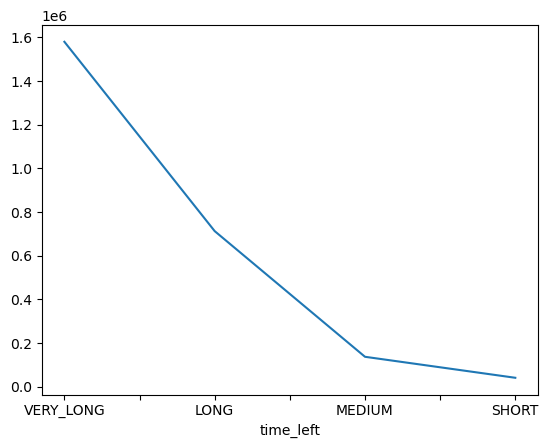

In [284]:
this_run_df['time_left'].value_counts().plot()

<Axes: xlabel='buyout'>

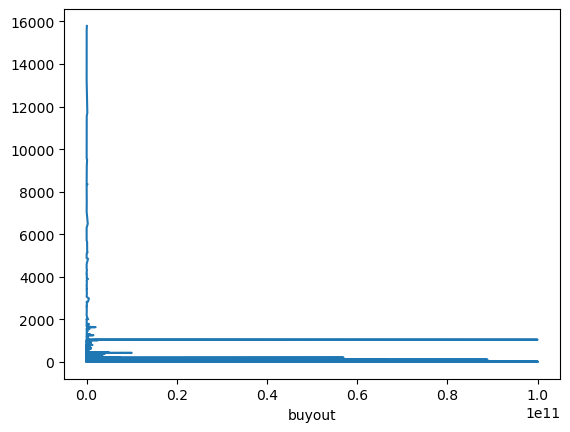

In [286]:
this_run_df['buyout'].value_counts().plot()

In [295]:
import matplotlib.pyplot as plt
 
x =[5, 7, 8, 7, 2, 17, 2, 9,
    4, 11, 12, 9, 6] 
 
y =[99, 86, 87, 88, 100, 86, 
    103, 87, 94, 78, 77, 85, 86]
 
plt.scatter(x, y, c ="blue")
 
# To show the plot
plt.show()

this_run_df['buyout'].value_counts()

buyout
5.000000e+07    15789
5.000000e+06    15577
1.000000e+07    15299
1.000000e+06    13778
5.000000e+05    13242
                ...  
1.429131e+09        1
2.957845e+08        1
6.180289e+09        1
8.365760e+07        1
6.973846e+08        1
Name: count, Length: 464215, dtype: int64

<Axes: xlabel='item.id'>

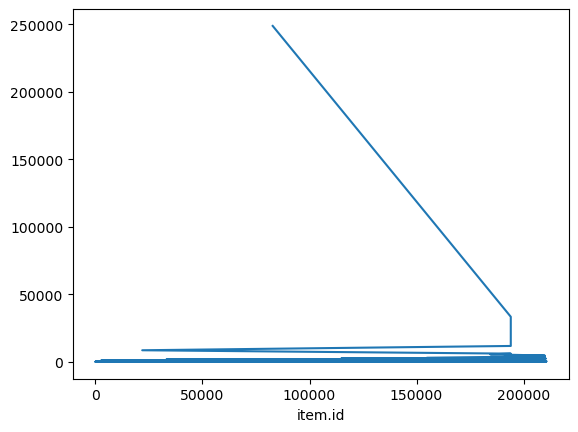

In [290]:
this_run_df['item.id'].value_counts().plot()

In [291]:
realm_counts=this_run_df['realm_id'].value_counts()

In [238]:
def get_realm_name(realm_id):
    return realms_df['realm_name'].loc[realms_df['realm_id']==realm_id]

In [277]:
realm_counts['realm_id'].unique()

array([  60,   57,   11,   61,   76,    5, 1136, 3725,   77, 1175,   73,
       1428,   86,  104,  162, 1129, 1427, 3209,   84,  127,  121, 3726,
         52, 3721,  125,   53,  113,   67, 1185,   71,  160,    9, 1138,
       3723,   96,  163, 1190,   55,   54,  106, 1072, 1070,   75, 1184,
        118,  158,   12,   64, 1147,  114,  101,  100,  157,    4,   69,
       1071,  117,   78,   63, 1425,  154,  115,   47,   99,  151,  120,
        155, 3208, 1151,   58, 3207, 3234], dtype=int64)

In [235]:
realms_df['realm_name'].loc[realms_df['realm_id']==1136]

91    Aegwynn
Name: realm_name, dtype: object

In [233]:
realms_df

,realm_id,realm_name
65,1,Lightbringer
68,2,Cenarius
66,3,Uther
52,4,Kilrogg
67,5,Proudmoore
...,...,...
236,3734,Nagrand
240,3735,Dath'Remar
243,3736,Jubei'Thos
244,3737,Gundrak


In [207]:
realm_counts['realm_id'].head(70)

0       60
1       57
2       11
3       61
4       76
      ... 
65     120
66     155
67    3208
68    1151
69      58
Name: realm_id, Length: 70, dtype: int64

In [278]:
realm_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   realm_id    72 non-null     int64 
 1   count       72 non-null     int64 
 2   realm_name  72 non-null     object
dtypes: int64(2), object(1)
memory usage: 1.8+ KB


In [279]:
realm_counts.sort_values('realm_id')

,realm_id,count,realm_name
53,4,14748,Gallywix
5,5,76542,Gallywix
31,9,30932,Gallywix
2,11,93543,Gallywix
46,12,19329,Gallywix
...,...,...,...
71,3234,5340,Gallywix
23,3721,39016,Gallywix
33,3723,29795,Gallywix
7,3725,73519,Gallywix


<Axes: >

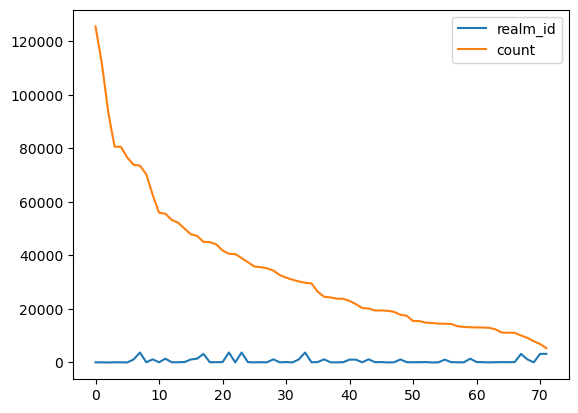

In [280]:
realm_counts.plot()

In [114]:
this_run_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459498 entries, 0 to 2459497
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   buyout               float64
 2   quantity             int64  
 3   time_left            object 
 4   item.id              int64  
 5   item.context         float64
 6   item.bonus_lists     object 
 7   item.modifiers       object 
 8   bid                  float64
 9   item.pet_breed_id    float64
 10  item.pet_level       float64
 11  item.pet_quality_id  float64
 12  item.pet_species_id  float64
 13  realm_id             int64  
 14  time_stamp           object 
dtypes: float64(7), int64(4), object(4)
memory usage: 281.5+ MB


In [ ]:
df.isna().sum()

In [ ]:
df['item.pet_breed_id'].value_counts().sum()/len(df)

In [ ]:
df.loc[df['item.pet_breed_id']>0]

In [ ]:
df['bid'].value_counts().sum()

In [ ]:
bonus_list=df['item.bonus_lists']
for item in bonus_list:
    if isinstance(item,list):
        if(len(item)>max):
            max=len(item)
            print(max, item)

In [ ]:
max=0

In [ ]:
exploded_bonus_list

In [ ]:
df['item.bonus_lists'].value_counts()

In [ ]:
df.loc[df['item.bonus_lists']==9527]

In [ ]:
modifiers=pd.json_normalize(df['item.modifiers'])
modifiers[0]

In [ ]:
type_28=pd.json_normalize(modifiers[0])
type_28

In [ ]:
type_28.value_counts()

In [ ]:
modifiers[1]

In [ ]:
type_29=pd.json_normalize(modifiers[1])
type_29

In [ ]:
bonus_list=pd.json_normalize(df['item.bonus_lists'])
bonus_list_list=pd.json_normalize(bonus_list[3])
bonus_list_list

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('C:/Users/Robert/Desktop/Project_1/auction_data.csv')
# remove data that is nan
df = df.dropna()
# Filter for the item 'Brain Hacker'
# Note: Adjust the column name 'item_name' to the actual column name in your CSV that holds the item names
brain_hacker_df = df[df['item.id'] == '1263']

# Extract the auction prices
# Note: Replace 'price' with the actual column name in your CSV that holds the prices
prices = brain_hacker_df['buyout']

# Plotting the prices
plt.figure(figsize=(10, 6))
plt.plot(prices, marker='o')
plt.title('Auction Prices for Brain Hacker')
plt.xlabel('Auction Entry')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [90]:
df=pd.read_csv('commodities_data_01-02-24.csv')

In [96]:
df.sort_values('id')

,id,quantity,unit_price,time_left,item.id
2717,1922545813,82,9500,SHORT,193214
5423,1922545884,12,9500,SHORT,193214
22850,1922546192,15,9500,SHORT,193214
10528,1922546412,15,9500,SHORT,193214
62000,1922546847,1,137000,SHORT,3712
...,...,...,...,...,...
311209,1930703333,2552,12700,LONG,190394
311210,1930703335,18,5150000,LONG,193936
311211,1930703340,5,2100,VERY_LONG,191461
311212,1930703341,458,35000,LONG,188658
